## Working with image data in `Mosaic`

In [1]:
from mosaic import DataPanel, ImageColumn
import numpy as np

## 💾 Download the data.
First, we'll download some data to explore. We're going to use the [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), a dataset of over 200k celebrity portraits, each annotated for 40 different attributes (e.g. "smiling", "bangs", "mustache").
- Download time: ~3 minutes
- Download size: 3.1G

In addition to downloading the data, `download_celeba` prepares a CSV, "celeba.csv", with a row for each image. 

In [2]:
from mosaic.contrib.celeba import download_celeba

DATASET_DIR = "/home/common/datasets/celeba"
download_celeba(DATASET_DIR)

## 📸 Create an image `DataPanel`

We're going to build a `DataPanel` out of "celeba.csv" file from the download above. 

1. Create a `DataPanel` from a CSV using the `DataPanel.from_csv` class method.
2. Create an `ImageColumn` from the the existing `"img_path"` column using the `DataPanel.from_filepaths` class method and add it to the the `DataPanel`. 

In [3]:
# 1. Create `DataPanel`
dp = DataPanel.from_csv(os.path.join(DATASET_DIR, "celeba.csv"))
# 2. Create `ImageColumn`
dp["img"] = ImageColumn.from_filepaths(filepaths=dp["img_path"])
dp.head()

### 🗂 Indexing.
When we create an `ImageColumn` we don't load the images into memory. Instead, `ImageColumn` keeps track of all those filepaths we passed in and only loads the images when they are accessed. 

Indexing the `ImageColumn` returns an object of type: <class 'PIL.Image.Image'>.


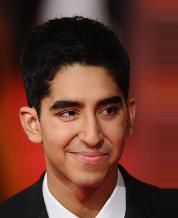

In [4]:
img = dp["img"][134]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")
display(img)

We can load a **batch** of images by indexing a slice. Notice that the output is a `ListColumn` of PIL images. 

In [5]:
img = dp["img"][12:16]
print(f"Indexing a slice of the `ImageColumn` returns a: {type(img)}.")
display(img)

Indexing a slice of the `ImageColumn` returns a: <class 'mosaic.columns.list_column.ListColumn'>.


,(ListColumn)
0,<PIL.Image.Image image mode=RGB size=178x218 a...
1,<PIL.Image.Image image mode=RGB size=178x218 a...
2,<PIL.Image.Image image mode=RGB size=178x218 a...
3,<PIL.Image.Image image mode=RGB size=178x218 a...


### 🧫 _Aside_: `ImageColumn` under the hood, `CellColumn`.

If you check out the implementation of `ImageColumn` (at "mosaic/columns/image_column.py"), you'll notice that it's a super simple subclass of `CellColumn`. 

_What's a `CellColumn`?_
In `mosaic`, high-dimensional data types like images and videos are typically stored in a `CellColumn`. The advantage of using `CellColumn` (or one of its subclasses) is that we can easily create new column types (e.g. for medical volumes, SpacyDocs, or graphs) without dealing with the implementation complexity of a full column. Instead, we can think in terms of the individual elements in the column: the cells.  We implement a cell by subclassing `AbstractCell` and overriding the `get` method. `get` is called when the cell is accessed, like in the example above. Below is a simple implemenation of an `ImageCell` (the actual cell used by `ImageColumn` is `mosaic.cells.imagepath.ImagePath`, which has a few additional features not included here): 


```
from mosaic.cells.abstract import AbstractCell
from torchvision.datasets.folder import default_loader

class ImageCell(AbstractCell):

    def __init__(self, filepath: str):
        super(ImagePath, self).__init__()
        self.filepath = filepath

    def get(self, *args, **kwargs):
        return default_loader(self.filepath)
    
    @classmethod
    def _state_keys(cls) -> Collection:
        return {"filepath"}
```
Notice that the `default_loader` isn't called on construction, only on `get`. Additionally, we need to specify the "_state_keys", the set of object attributes needed to recreate the cell. When writing the cell to disk, only these attributes are written. 

### 🦥 Lazy indexing.
What if we don't want to load the images? To access the underlying cell (without loading the image), use the lazy indexer, `lz`.

In [57]:
cell = dp["img"].lz[14]
print(f"Lazy indexing the `ImageColumn` returns an object of type: {type(cell)}.")
display(cell)

Lazy indexing the `ImageColumn` returns an object of type: <class 'mosaic.cells.imagepath.ImagePath'>.


ImagePathCell(162785.jpg)

Note: **cells can survive on their own.** Everything we need to materialize the cell (e.g. the filepath to the image and the loading function) lives inside the cell, so we can call `cell.get()` to load the image even after the cell has been isolated from it's original column. 

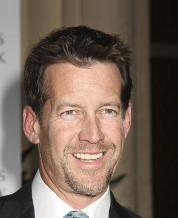

In [58]:
cell.get()

Using the lazy indexer and one of the following indexing schemmes, we can also access a **subset** of a `CellColumn`, which is itself a `CellColumn`.
- **Slice indexing**: _e.g._ `column.lz[4:10]`
- **Integer array indexing**: _e.g._ `column.lz[[0,4, 6, 11]]`
- **Boolean array indexing**: _e.g._ `column.lz[np.array([True,False, False ..., True, False])]`

In [60]:
cells = dp["img"].lz[12:16]
print(f"Lazy indexing a slice of the `ImageColumn` returns an object of type: {type(cells)}.")
display(cells)

Lazy indexing a slice of the `ImageColumn` returns an object of type: <class 'mosaic.columns.image_column.ImageColumn'>.


,(ImageColumn)
0,ImagePathCell(162783.jpg)
1,ImagePathCell(162784.jpg)
2,ImagePathCell(162785.jpg)
3,ImagePathCell(162786.jpg)


## 🛠 Applying operations over the DataPanel.

When training and evaluating our models, we often perform operations on each example in our dataset (e.g. compute a model's prediction on each example, tokenize each sentence, compute a model's embedding for each example) and store them. The `DataPanel` makes it easy to perform these operations:  
- Produce new columns (via `DataPanel.map`)
- Produce new columns and store the columns alongside the original data (via `DataPanel.update`)
- Extract an important subset of the datset (via `DataPanel.filter`).   

Under the hood, dataloading is multiprocessed so that costly I/O doesn't bottleneck our computation.

Let's start by filtering the `DataPanel` down to the first 1,000 examples in the validation set. Note that we use the lazy indexer `lz` to avoid loading all of the images. 

In [8]:
dp = dp.lz[dp["split"].data == "valid"].lz[:1000]

### 🍎  Use `DataPanel.map` to compute average intensity of the red color channel in the images.

To demonstrate the utility `map` operation, we'll explore the relationship between the "redness" of an image and the hair color of the person in the image. 

We'll quantify the "redness" of each image by simply computing the mean intensity of the red color channel. This can be accomplished with a simple `map` operation over the `DataPanel`:

In [9]:
red_col = dp.map(
    lambda x: np.array(x["img"])[:, :, 0].mean(), 
    pbar=True, 
    num_workers=4
)
dp["avg_red"] = red_col  # add the intensities as a new column in the `DataPanel` 
red_col[:4]

,(NumpyArrayColumn)
0,77.174286
1,158.142872
2,97.688202
3,90.469178


Next, we'll explore the relationship between redness and the hair color of the celebrity in the image. To do so, we'll compare the average red intensity distribution of celebrities with blond hair to celebrities with other hair colors. 
Using the [`seaborn`](https://seaborn.pydata.org/installing.html) plotting package and our `DataPanel`, this can be accomplished in one line: 

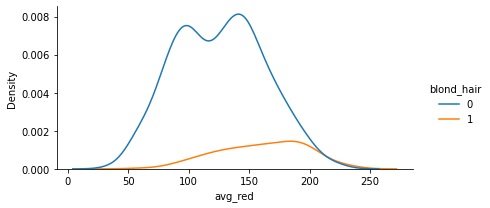

In [76]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
sns.displot(
    data=dp.to_pandas(), 
    x="avg_red", 
    hue="blond_hair", 
    kind="kde", 
    height=3, 
    aspect=2
);

Looks like images of celebrities with blonde hair tend to be a bit more red!

## 📉 ML with images in `mosaic`.

In [11]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

In [12]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.Lambda(lambda x: torch.from_numpy(np.array(x))),
        transforms.Lambda(lambda x: x.permute(2, 0, 1)),
        transforms.Lambda(lambda x: x.to(torch.float)),
    ]
)
dp["input"] = ImageColumn.from_filepaths(filepaths=dp["img_path"], transform=transform)

In [26]:
class ActivationExtractor:
    """Class for extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def add_hook(self, module, input, output):
        self.activation = output

extractor = ActivationExtractor()
model.layer4.register_forward_hook(extractor.add_hook)
 
model.to(0).eval()
@torch.no_grad()
def predict(batch: dict):
    out = torch.softmax(model(batch["input"].data.to(0)), axis=-1)
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": out.cpu().numpy(),
        "activation": extractor.activation.mean(dim=[-1,-2]).cpu().numpy()
    }

In [27]:
dp = dp.update(
    function=predict,
    batched=True,
    input_columns=["input"],
    pbar=True
)

In [54]:
from umap import UMAP
reducer = UMAP()
embs = reducer.fit_transform(dp["activation"])
dp["umap_0"] = embs[:, 0]
dp["umap_1"] = embs[:, 1]

<AxesSubplot:xlabel='umap_0', ylabel='umap_1'>

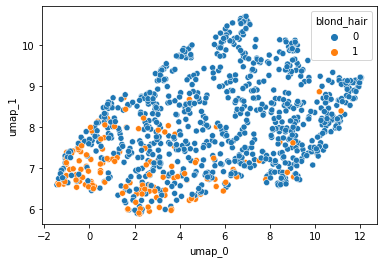

In [55]:
import seaborn as sns
sns.scatterplot(data=dp.to_pandas(), x="umap_0", y="umap_1", hue="blond_hair")